---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---


# Saving and Loading {#sec-spotpython-saving-and-loading}

This tutorial shows how to save and load objects in `spotpython`.
It is split into the following parts:
- @sec-spotpython-saving-and-loading shows how to save and load objects in `spotpython`, if `spotpython` is used as an optimizer.
- @sec-spotpython-as-a-hyperparameter-tuner-37 shows how to save and load hyperparameter tuning experiments.
- @sec-saving-and-loading-pytorch-lightning-models-37 shows how to save and load `PyTorch Lightning` models.
- @sec-converting-a-lightning-model-to-a-plain-torch-model-37 shows how to convert a `PyTorch Lightning` model to a plain `PyTorch` model.

## spotpython: Saving and Loading Optimization Experiments {#sec-spotpython-saving-and-loading}

In this section, we will show how results from `spotpython` can be saved and reloaded.
Here, `spotpython` can be used as an optimizer. 

### spotpython as an Optimizer

If `spotpython` is used as an optimizer, no dictionary of hyperparameters has be specified. The `fun_control` dictionary is sufficient. 


In [1]:
#| label: code-optimization-experiment-604
import os
import pprint
from spotpython.utils.file import load_experiment
from spotpython.utils.file import get_experiment_filename
import numpy as np
from math import inf
from spotpython.spot import spot
from spotpython.utils.init import (
    fun_control_init,
    design_control_init,
    surrogate_control_init,
    optimizer_control_init)
from spotpython.fun.objectivefunctions import analytical
fun = analytical().fun_branin
fun_control = fun_control_init(
            PREFIX="branin",            
            lower = np.array([0, 0]),
            upper = np.array([10, 10]),
            fun_evals=8,
            fun_repeats=1,
            max_time=inf,
            noise=False,
            tolerance_x=0,
            ocba_delta=0,
            var_type=["num", "num"],
            infill_criterion="ei",
            n_points=1,
            seed=123,
            log_level=20,
            show_models=False,
            show_progress=True)
design_control = design_control_init(
            init_size=5,
            repeats=1)
surrogate_control = surrogate_control_init(
            model_fun_evals=10000,
            min_theta=-3,
            max_theta=3,
            n_theta=2,
            theta_init_zero=True,
            n_p=1,
            optim_p=False,
            var_type=["num", "num"],
            seed=124)
optimizer_control = optimizer_control_init(
            max_iter=1000,
            seed=125)
spot_tuner = spot.Spot(fun=fun,
            fun_control=fun_control,
            design_control=design_control,
            surrogate_control=surrogate_control,
            optimizer_control=optimizer_control)
spot_tuner.run()
PREFIX = fun_control["PREFIX"]
filename = get_experiment_filename(PREFIX)
spot_tuner.save_experiment(filename=filename)
print(f"filename: {filename}")

Seed set to 123
Seed set to 123


spotpython tuning: 4.7932399644479124 [########--] 75.00% 
spotpython tuning: 2.0379524815147736 [#########-] 87.50% 
spotpython tuning: 1.9863250753932071 [##########] 100.00% Done...

Experiment saved to spot_branin_experiment.pickle
filename: spot_branin_experiment.pickle


In [2]:
#| label: code-reload-optimization-experiment-604
(spot_tuner_1, fun_control_1, design_control_1,
    surrogate_control_1, optimizer_control_1) = load_experiment(filename)

Loaded experiment from spot_branin_experiment.pickle


The progress of the original experiment is shown in @fig-plot-progress-37a and the reloaded experiment in @fig-plot-progress-37b.

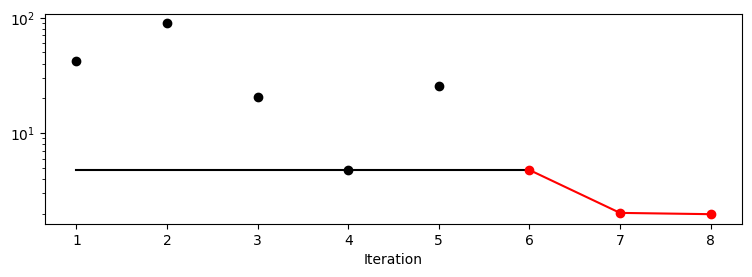

In [3]:
#| label: fig-plot-progress-604
#| fig-cap: Progress of the original experiment
spot_tuner.plot_progress(log_y=True)

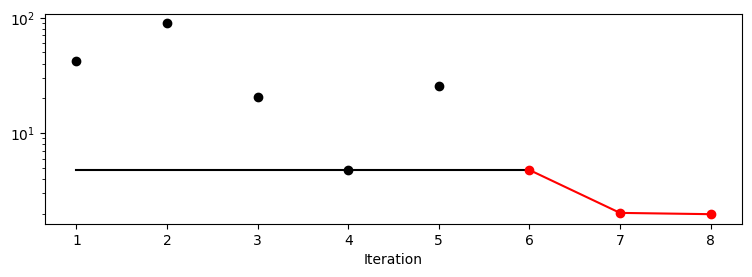

In [4]:
#| label: fig-plot-progress-604
#| fig-cap: Progress of the reloaded experiment
spot_tuner_1.plot_progress(log_y=True)

The results from the original experiment are shown in @tbl-results-37a and the reloaded experiment in @tbl-results-37b.

In [5]:
#| label: tbl-results-604a
spot_tuner.print_results()

min y: 1.9863250753932071
x0: 10.0
x1: 3.2107652010539627


[['x0', 10.0], ['x1', 3.2107652010539627]]

In [6]:
#| label: tbl-results-604b
spot_tuner_1.print_results()

min y: 1.9863250753932071
x0: 10.0
x1: 3.2107652010539627


[['x0', 10.0], ['x1', 3.2107652010539627]]

#### Getting the Tuned Hyperparameters

The tuned hyperparameters can be obtained as a dictionary with the following code.

In [7]:
#| label: code-get-tuned-optimization-604
from spotpython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner=spot_tuner)

{'x0': 10.0, 'x1': 3.2107652010539627}

::: {.callout-note}
### Summary: Saving and Loading Optimization Experiments
* If `spotpython` is used as an optimizer (without an hyperparameter dictionary), experiments can be saved and reloaded with the `save_experiment` and `load_experiment` functions.
* The tuned hyperparameters can be obtained with the `get_tuned_hyperparameters` function.
:::

## spotpython as a Hyperparameter Tuner {#sec-spotpython-as-a-hyperparameter-tuner-37}

If `spotpython` is used as a hyperparameter tuner,
in addition to the `fun_control` dictionary a `core_model` dictionary has to be specified.
Furthermore, a data set has to be selected and added to the `fun_control` dictionary.
Here, we will use the `Diabetes` data set.

In [8]:
#| label: warnings-off-604
import warnings
warnings.filterwarnings("ignore")



### The Diabetes Data Set

The hyperparameter tuning of a `PyTorch Lightning` network on the `Diabetes` data set is used as an example. The `Diabetes` data set is a PyTorch Dataset for regression, which originates from the `scikit-learn` package, see [https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes).

Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients,  as well as the response of interest, a quantitative measure of disease progression one year after baseline.
The `Diabetes` data set is has the following properties:

* Samples total: 442
* Dimensionality: 10
* Features: real, $-.2 < x < .2$
* Targets: integer $25 - 346$

In [9]:
#| label: code-hyperparameter-tuning-604
from spotpython.data.diabetes import Diabetes
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import gen_design_table
from spotpython.spot import spot
from spotpython.utils.file import get_experiment_filename

PREFIX="604"

data_set = Diabetes()

fun_control = fun_control_init(
    PREFIX=PREFIX,
    fun_evals=inf,
    max_time=1,
    data_set = data_set,
    core_model_name="light.regression.NNLinearRegressor",
    hyperdict=LightHyperDict,
    _L_in=10,
    _L_out=1)

fun = HyperLight().fun

from spotpython.hyperparameters.values import set_hyperparameter
set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "l1", [3,4])
set_hyperparameter(fun_control, "epochs", [3,5])
set_hyperparameter(fun_control, "batch_size", [4,11])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [2,3])

design_control = design_control_init(init_size=10)

print(gen_design_table(fun_control))

Seed set to 123


module_name: light
submodule_name: regression
model_name: NNLinearRegressor
| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     3   |   4     | transform_power_2_int |
| epochs         | int    | 4         |     3   |   5     | transform_power_2_int |
| batch_size     | int    | 4         |     4   |  11     | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |   5     | None                  |
| optimizer      | factor | SGD       |     0   |   2     | None                  |
| dropout_prob   | float  | 0.01      |     0   |   0.025 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |  10     | None                  |
| patience       | int    | 2         |     2   |   3     | transform_power_2_int |
| batch_norm     | factor | 0         |     0   |   1     | None                  |


In [10]:
#| label: 604_save_experiment
fun_control.update({"save_experiment": True})

In [11]:
spot_tuner = spot.Spot(fun=fun,fun_control=fun_control, design_control=design_control)
spot_tuner.save_experiment(path="userExperiment", overwrite=False)
res = spot_tuner.run()

Error: File userExperiment/spot_604_experiment.pickle already exists. Use overwrite=True to overwrite the file.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [64, 10] | [64, 1]  
-----------------------------------------------------

train_model result: {'val_loss': 23995.974609375, 'hp_metric': 23995.974609375}


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 595    | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
595       Trainable params
0         Non-trainable params
595       Total params
0.002     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24026.373046875, 'hp_metric': 24026.373046875}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23620.58984375, 'hp_metric': 23620.58984375}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 595    | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
595       Trainable params
0         Non-trainable params
595       Total params
0.002     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24180.556640625, 'hp_metric': 24180.556640625}


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23952.33984375, 'hp_metric': 23952.33984375}


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24038.296875, 'hp_metric': 24038.296875}


`Trainer.fit` stopped: `max_epochs=8` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23852.763671875, 'hp_metric': 23852.763671875}


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 22770.60546875, 'hp_metric': 22770.60546875}


`Trainer.fit` stopped: `max_epochs=16` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 595    | train | [1024, 10] | [1024, 1]
-----------------------------------------------------------------------
595       Trainable params
0         Non-trainable params
595       Total params
0.002     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23918.626953125, 'hp_metric': 23918.626953125}


`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23849.54296875, 'hp_metric': 23849.54296875}
train_model result: {'val_loss': 23422.236328125, 'hp_metric': 23422.236328125}
spotpython tuning: 22770.60546875 [----------] 2.50% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 23982.087890625, 'hp_metric': 23982.087890625}
spotpython tuning: 22770.60546875 [#---------] 5.01% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23473.16796875, 'hp_metric': 23473.16796875}
spotpython tuning: 22770.60546875 [#---------] 9.93% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
491       Trainable params
0         No

train_model result: {'val_loss': nan, 'hp_metric': nan}


`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 22629.123046875, 'hp_metric': 22629.123046875}
spotpython tuning: 22629.123046875 [#---------] 13.35% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 3496.171630859375, 'hp_metric': 3496.171630859375}
spotpython tuning: 3496.171630859375 [##--------] 15.40% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 4889.92919921875, 'hp_metric': 4889.92919921875}
spotpython tuning: 3496.171630859375 [##--------] 17.75% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 4024.494140625, 'hp_metric': 4024.494140625}
spotpython tuning: 3496.171630859375 [##--------] 20.55% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 8961.015625, 'hp_metric': 8961.015625}
spotpython tuning: 3496.171630859375 [##--------] 23.21% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 23947.6796875, 'hp_metric': 23947.6796875}
spotpython tuning: 3496.171630859375 [###-------] 27.48% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 13458.3916015625, 'hp_metric': 13458.3916015625}
spotpython tuning: 3496.171630859375 [###-------] 32.28% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes   | Out sizes
-----------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [2048, 10] | [2048, 1]
-----------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 24036.61328125, 'hp_metric': 24036.61328125}
spotpython tuning: 3496.171630859375 [###-------] 34.35% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24099.958984375, 'hp_metric': 24099.958984375}
spotpython tuning: 3496.171630859375 [####------] 36.86% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 213    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 24036.01953125, 'hp_metric': 24036.01953125}
spotpython tuning: 3496.171630859375 [####------] 39.69% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [512, 10] | [512, 1] 
----------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 21390.390625, 'hp_metric': 21390.390625}
spotpython tuning: 3496.171630859375 [####------] 41.82% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 4198.23046875, 'hp_metric': 4198.23046875}
spotpython tuning: 3496.171630859375 [#####-----] 45.34% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 3311.99951171875, 'hp_metric': 3311.99951171875}
spotpython tuning: 3311.99951171875 [#####-----] 52.13% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 20298.36328125, 'hp_metric': 20298.36328125}
spotpython tuning: 3311.99951171875 [#######---] 66.06% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [16, 10] | [16, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=8` reached.


train_model result: {'val_loss': 24013.935546875, 'hp_metric': 24013.935546875}
spotpython tuning: 3311.99951171875 [########--] 75.96% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [32, 10] | [32, 1]  
---------------------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23315.51953125, 'hp_metric': 23315.51953125}
spotpython tuning: 3311.99951171875 [########--] 83.86% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 169    | train | [256, 10] | [256, 1] 
----------------------------------------------------------------------
169       Trainable params
0         Non-trainable params
169       Total params
0.001     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=32` reached.


train_model result: {'val_loss': 23904.419921875, 'hp_metric': 23904.419921875}
spotpython tuning: 3311.99951171875 [#########-] 88.78% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 19753.544921875, 'hp_metric': 19753.544921875}
spotpython tuning: 3311.99951171875 [##########] 98.25% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes  | Out sizes
----------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [128, 10] | [128, 1] 
----------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=16` reached.


train_model result: {'val_loss': 22323.83984375, 'hp_metric': 22323.83984375}
spotpython tuning: 3311.99951171875 [##########] 100.00% Done...

Experiment saved to spot_604_experiment.pickle


The tuned hyperparameters can be obtained as a dictionary with the following code.

In [12]:
#| label: code-get-tuned-hyperparameters-37
from spotpython.hyperparameters.values import get_tuned_hyperparameters
get_tuned_hyperparameters(spot_tuner)

{'l1': 4.0,
 'epochs': 4.0,
 'batch_size': 6.0,
 'act_fn': 3.0,
 'optimizer': 0.0,
 'dropout_prob': 0.0014073672542928583,
 'lr_mult': 8.589535521580487,
 'patience': 3.0,
 'batch_norm': 0.0,
 'initialization': 1.0}

Here , the numerical levels of the hyperparameters are used as keys in the dictionary.
If the `fun_control` dictionary is used, the names of the hyperparameters are used as keys in the dictionary. 

In [13]:
#| label: code-get-tuned-hyperparameters-fun-ctrl37
get_tuned_hyperparameters(spot_tuner, fun_control)

{'l1': 4.0,
 'epochs': 4.0,
 'batch_size': 6.0,
 'act_fn': 'LeakyReLU',
 'optimizer': 'Adadelta',
 'dropout_prob': 0.0014073672542928583,
 'lr_mult': 8.589535521580487,
 'patience': 3.0,
 'batch_norm': 0,
 'initialization': 'kaiming_uniform'}

In [14]:
#| label: code-save-experiment-37
spot_tuner.save_experiment(path="userExperiment", overwrite=False)

Error: File userExperiment/spot_604_experiment.pickle already exists. Use overwrite=True to overwrite the file.


The results from the experiment are stored in the pickle file `{python} filename`.
The experiment can be reloaded with the following code.

In [15]:
print(f"filename: {filename}")

filename: spot_branin_experiment.pickle


In [16]:
#| label: code-reload-hyper-experiment-37
from spotpython.utils.file import load_experiment
(spot_tuner_1, fun_control_1, design_control_1,
    surrogate_control_1, optimizer_control_1) = load_experiment(PREFIX=PREFIX)

Loaded experiment from spot_604_experiment.pickle


Plot the progress of the original experiment are identical to the reloaded experiment.

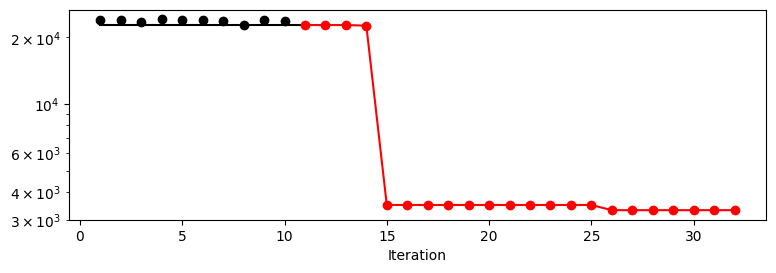

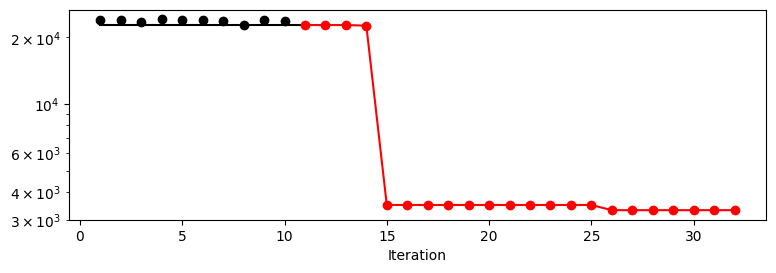

In [17]:
spot_tuner.plot_progress(log_y=True)
spot_tuner_1.plot_progress(log_y=True)

Finally, the tuned hyperparameters can be obtained as a dictionary from the reloaded experiment with the following code.

In [18]:
get_tuned_hyperparameters(spot_tuner_1, fun_control_1)

{'l1': 4.0,
 'epochs': 4.0,
 'batch_size': 6.0,
 'act_fn': 'LeakyReLU',
 'optimizer': 'Adadelta',
 'dropout_prob': 0.0014073672542928583,
 'lr_mult': 8.589535521580487,
 'patience': 3.0,
 'batch_norm': 0,
 'initialization': 'kaiming_uniform'}

::: {.callout-note}
### Summary: Saving and Loading Hyperparameter-Tuning Experiments
* If `spotpython` is used as an hyperparameter tuner (with an hyperparameter dictionary), experiments can be saved and reloaded with the `save_experiment` and `load_experiment` functions.
* The tuned hyperparameters can be obtained with the `get_tuned_hyperparameters` function.
:::


## Saving and Loading PyTorch Lightning Models {#sec-saving-and-loading-pytorch-lightning-models-37}

@sec-spotpython-saving-and-loading  and @sec-spotpython-as-a-hyperparameter-tuner-37 explained how to save and load optimization and hyperparameter tuning experiments and how to get the tuned hyperparameters as a dictionary.
This section shows how to save and load `PyTorch Lightning` models.


### Get the Tuned Architecture {#sec-get-spot-results-31}

In contrast to the function `get_tuned_hyperparameters`, the function `get_tuned_architecture` returns the tuned architecture of the model as a dictionary. Here, the transformations are already applied to the numerical levels of the hyperparameters and the encoding (and types) are the original types of the hyperparameters used by the model. The `config` dictionary can be passed to the model without any modifications.

In [19]:
from spotpython.hyperparameters.values import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)
pprint.pprint(config)

{'act_fn': LeakyReLU(),
 'batch_norm': False,
 'batch_size': 64,
 'dropout_prob': 0.0014073672542928583,
 'epochs': 16,
 'initialization': 'kaiming_uniform',
 'l1': 16,
 'lr_mult': 8.589535521580487,
 'optimizer': 'Adadelta',
 'patience': 8}


After getting the tuned architecture, the model can be created and tested with the following code.

In [20]:
from spotpython.light.testmodel import test_model
test_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------
0 | layers | Sequential | 491    | train | [64, 10] | [64, 1]  
---------------------------------------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
Restoring states from the checkpoint path at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/16_16_64_LeakyReLU_Adadelta_0.0014_8.5895_8_False_kaiming_uniform_TEST/last-v2.ckpt
Loaded model weights from the checkpoint at /Users/bartz/workspace/Hyperparameter-Tuning-Cookbook/runs/saved_models/16_16_64_LeakyReLU_Adadelta_0.0014_8.5895_8_False_kaiming_uniform_TEST/last-v2.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │      19425.208984375      │
│         val_loss          │      19425.208984375      │
└───────────────────────────┴───────────────────────────┘

test_model result: {'val_loss': 19425.208984375, 'hp_metric': 19425.208984375}


(19425.208984375, 19425.208984375)

### Load a Model from Checkpoint

In [21]:
from spotpython.light.loadmodel import load_light_from_checkpoint
model_loaded = load_light_from_checkpoint(config, fun_control)

config: {'l1': 16, 'epochs': 16, 'batch_size': 64, 'act_fn': LeakyReLU(), 'optimizer': 'Adadelta', 'dropout_prob': 0.0014073672542928583, 'lr_mult': 8.589535521580487, 'patience': 8, 'batch_norm': False, 'initialization': 'kaiming_uniform'}
Loading model with 16_16_64_LeakyReLU_Adadelta_0.0014_8.5895_8_False_kaiming_uniform_TEST from runs/saved_models/16_16_64_LeakyReLU_Adadelta_0.0014_8.5895_8_False_kaiming_uniform_TEST/last.ckpt
Model: NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): LeakyReLU()
    (2): Dropout(p=0.0014073672542928583, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): LeakyReLU()
    (5): Dropout(p=0.0014073672542928583, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): LeakyReLU()
    (8): Dropout(p=0.0014073672542928583, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): LeakyReLU()
    (11): Dropout(p=0.00

In [22]:
vars(model_loaded)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('layers',
               Sequential(
                 (0): Linear(in_features=10, out_features=16, bias=True)
                 (1): LeakyReLU()
                 (2): Dropout(p=0.0014073672542928583, inplace=False)
                 (3): Linear(in_features=16, out_features=8, bias=True)
                 (4): LeakyReLU()
                 (5): Dropout(p=0.0014073

In [23]:
import torch
torch.save(model_loaded, "model.pt")

In [24]:
mymodel = torch.load("model.pt")

In [25]:
# show all attributes of the model
vars(mymodel)

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('layers',
               Sequential(
                 (0): Linear(in_features=10, out_features=16, bias=True)
                 (1): LeakyReLU()
                 (2): Dropout(p=0.0014073672542928583, inplace=False)
                 (3): Linear(in_features=16, out_features=8, bias=True)
                 (4): LeakyReLU()
                 (5): Dropout(p=0.0014073

## Converting a Lightning Model to a Plain Torch Model {#sec-converting-a-lightning-model-to-a-plain-torch-model-37}

### The Function `get_removed_attributes_and_base_net`

`spotpython` provides a function to covert a `PyTorch Lightning` model to a plain `PyTorch` model. The function `get_removed_attributes_and_base_net` returns a tuple with the removed attributes and the base net. The base net is a plain `PyTorch` model. The removed attributes are the attributes of the `PyTorch Lightning` model that are not part of the base net.

This conversion can be reverted.

In [26]:
import numpy as np
import torch
from spotpython.utils.device import getDevice
from torch.utils.data import random_split
from spotpython.utils.classes import get_removed_attributes_and_base_net
from spotpython.hyperparameters.optimizer import optimizer_handler
removed_attributes, torch_net = get_removed_attributes_and_base_net(net=mymodel)

In [27]:
print(removed_attributes)

{'_log_hyperparams': True, 'prepare_data_per_node': True, '_device_mesh': None, '_compiler_ctx': None, '_fabric_optimizers': [], '_hparams_name': 'kwargs', '_param_requires_grad_state': {}, '_dtype': torch.float32, '_device': device(type='mps', index=0), '_hparams_initial': "act_fn":         LeakyReLU()
"batch_norm":     False
"batch_size":     64
"dropout_prob":   0.0014073672542928583
"epochs":         16
"initialization": kaiming_uniform
"l1":             16
"lr_mult":        8.589535521580487
"optimizer":      Adadelta
"patience":       8, '_fabric': None, '_torchmetric': 'mean_squared_error', '_automatic_optimization': True, '_example_input_array': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [28]:
print(torch_net)

NNLinearRegressor(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): LeakyReLU()
    (2): Dropout(p=0.0014073672542928583, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): LeakyReLU()
    (5): Dropout(p=0.0014073672542928583, inplace=False)
    (6): Linear(in_features=8, out_features=8, bias=True)
    (7): LeakyReLU()
    (8): Dropout(p=0.0014073672542928583, inplace=False)
    (9): Linear(in_features=8, out_features=4, bias=True)
    (10): LeakyReLU()
    (11): Dropout(p=0.0014073672542928583, inplace=False)
    (12): Linear(in_features=4, out_features=4, bias=True)
    (13): LeakyReLU()
    (14): Dropout(p=0.0014073672542928583, inplace=False)
    (15): Linear(in_features=4, out_features=4, bias=True)
    (16): LeakyReLU()
    (17): Dropout(p=0.0014073672542928583, inplace=False)
    (18): Linear(in_features=4, out_features=2, bias=True)
    (19): LeakyReLU()
    (20): Dropout(p=0.0014073672542928583, inplac

###  An Example how to use the Plain Torch Net

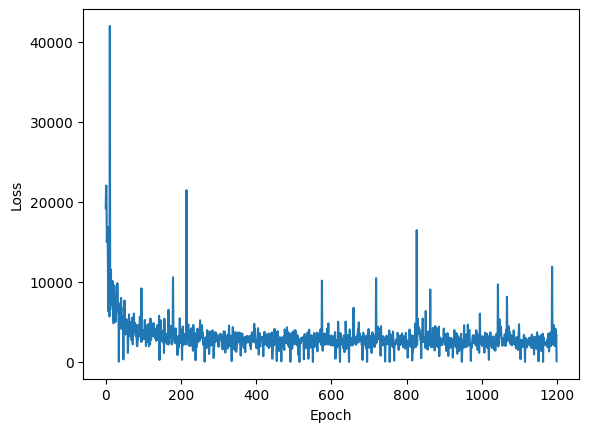

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the Diabetes dataset from sklearn
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a PyTorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a PyTorch dataloader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

torch_net.to(getDevice("cpu"))

# train the net
criterion = nn.MSELoss()
optimizer = optim.Adam(torch_net.parameters(), lr=0.01)
n_epochs = 100
losses = []
for epoch in range(n_epochs):
    for inputs, targets in train_dataloader:
        targets = targets.view(-1, 1)
        optimizer.zero_grad()
        outputs = torch_net(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
# visualize the network training
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()